# 1. Project Overview
Zone Classification for Bilbao Housing Listings
This notebook builds a multi-class classifier to predict the zone of a property in Bilbao using structured listing features.
Pipeline Outline:
1. Data loading & basic preprocessing (drop non-predictive text, cast object -> categorical).
2. Target definition: predict broader zone (remove neighborhood for generalization).
3. Multiple modeling strategies (encoded vs native categorical handling, SVM dimensionality reduction, class weighting).
4. Rich evaluation metrics emphasizing macro F1 and Matthews correlation for imbalanced classes.
5. Progressive hyperparameter tuning: wide RandomizedSearch, refined RandomizedSearch, Optuna optimization.
6. Feature engineering: create price_per_m2 feature to improve separability.
7. Final champion LightGBM model retrained with optimized parameters + engineered feature.
8. Interpretability: feature importance ranking, confusion matrix, minority class error analysis.
9. Model persistence (joblib dump).

## 2. Imports

In [37]:
# Core imports
import pandas as pd
import numpy as np
import re

# Model imports (baseline + advanced)
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Preprocessing & evaluation imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate, StratifiedKFold

## 3. Data Loading & Basic Preprocessing

In [38]:
data = pd.read_csv('../data/cleaned/data_final.csv')

# Drop non-predictive free-text columns
data = data.drop(columns=["url", "description"])

# Cast object/text columns to categorical dtype for algorithms that support native categorical handling
for col in data.select_dtypes(include=['object']).columns:
    data[col] = data[col].astype('category')

# Optional inspection
# data.info()
# data.head()

## 4. Problem Definition: Zone Classification
We aim to predict the broader `zone` category for each property listing. The more granular `neighborhood` column is removed to focus on generalized zone placement.

### 5. Feature / Target Separation

In [39]:
# Remove neighborhood to classify broader zone
data_zone = data.drop(columns=["neighborhood"])

# Split predictors and target
X_zone = data_zone.drop(columns=["zone"])
y_zone = data_zone["zone"]

# Optional sanity checks
# print(y_zone.head())
# X_zone.head()

### 6. Evaluation Setup: Metrics & Model Zoo

In [40]:
# Multi-metric scoring for imbalance & multi-class quality
SCORING = {
    'accuracy': 'accuracy',
    'recall_weighted': 'recall_weighted',
    'precision_weighted': 'precision_weighted',
    'f1_weighted': 'f1_weighted',
    'f1_macro': 'f1_macro',        # Critical: reveals performance on minority classes
    'matthews': 'matthews_corrcoef',
    'balanced_accuracy': 'balanced_accuracy'
}

# Diverse baseline and advanced models
MODELS = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Random Forest (tuned)': RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_split=5, random_state=42, n_jobs=-1),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial'),
    'Naive Bayes': GaussianNB(),
    # 'SVM (Linear)': SVC(kernel='linear', random_state=42, probability=True),  # commented due to runtime cost
    # 'SVM (RBF)': SVC(kernel='rbf', random_state=42, probability=True),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Hist Gradient Boosting': HistGradientBoostingClassifier(max_iter=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'CatBoost': CatBoostClassifier(iterations=100, random_state=42, verbose=0, allow_writing_files=False),
    'Neural Network (MLP)': make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42))
}

# Stratified CV preserves class distribution
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### 7. Model Evaluation Helper

In [41]:
def evaluate_models(X, y, cv_strategy=cv_strategy, scoring=SCORING, models=MODELS):
    """Cross-validate a dictionary of models, returning mean/std for each metric."""
    results = {}
    for name, model in models.items():
        print(f"\n{name}:")
        scores = cross_validate(model, X, y, cv=cv_strategy, scoring=scoring, return_train_score=False, n_jobs=-1)
        results[name] = {}
        for metric_name, metric_scores in scores.items():
            if metric_name.startswith('test_'):
                metric = metric_name.replace('test_', '')
                results[name][metric] = (metric_scores.mean(), metric_scores.std())
                print(f"  {metric}: {metric_scores.mean():.4f} (+/- {metric_scores.std():.4f})")
    return results

### 8. Strategy 1: One-Hot Encode Selected Categoricals

In [42]:
# Strategy 1
print("="*80)
print("Strategy 1: Use all variables; one-hot encode selected categorical features")
print("="*80)

cat_cols1 = ["exterior", "condition", "agency", "consumption_label", "emissions_label"]

X_zone_encoded_1 = pd.get_dummies(X_zone, columns=cat_cols1)
# Remove special characters from column names to avoid issues in certain models
X_zone_encoded_1.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_zone_encoded_1.columns]
y_zone_encoded_1 = LabelEncoder().fit_transform(y_zone)

print(f"\nSamples: {len(X_zone_encoded_1)}")
print(f"Features: {X_zone_encoded_1.shape[1]}")
print(f"Class distribution: {np.bincount(y_zone_encoded_1)}")

result1 = evaluate_models(X_zone_encoded_1, y_zone_encoded_1, models=MODELS, cv_strategy=cv_strategy)

print("\n" + "="*80)

Strategy 1: Use all variables; one-hot encode selected categorical features

Samples: 1230
Features: 324
Class distribution: [237 127  76  61  90 156 136  34 167  33 113]

Random Forest:
  accuracy: 0.6073 (+/- 0.0225)
  recall_weighted: 0.6073 (+/- 0.0225)
  precision_weighted: 0.6346 (+/- 0.0297)
  f1_weighted: 0.5966 (+/- 0.0253)
  f1_macro: 0.5697 (+/- 0.0380)
  matthews: 0.5531 (+/- 0.0262)
  balanced_accuracy: 0.5439 (+/- 0.0370)

Random Forest (tuned):
  accuracy: 0.6073 (+/- 0.0225)
  recall_weighted: 0.6073 (+/- 0.0225)
  precision_weighted: 0.6346 (+/- 0.0297)
  f1_weighted: 0.5966 (+/- 0.0253)
  f1_macro: 0.5697 (+/- 0.0380)
  matthews: 0.5531 (+/- 0.0262)
  balanced_accuracy: 0.5439 (+/- 0.0370)

Random Forest (tuned):
  accuracy: 0.5707 (+/- 0.0186)
  recall_weighted: 0.5707 (+/- 0.0186)
  precision_weighted: 0.6337 (+/- 0.0337)
  f1_weighted: 0.5493 (+/- 0.0209)
  f1_macro: 0.5133 (+/- 0.0309)
  matthews: 0.5133 (+/- 0.0213)
  balanced_accuracy: 0.4814 (+/- 0.0293)

Logis

### 9. Strategy 1.1: Native Categorical Handling

In [ ]:
# Models that natively handle categorical features
MODELS_NATIVE = {
    'XGBoost': XGBClassifier(
        n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1,
        tree_method="hist", enable_categorical=True, use_label_encoder=False, eval_metric='mlogloss'
    ),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbose=-1),
    'CatBoost': CatBoostClassifier(iterations=100, random_state=42, verbose=0, allow_writing_files=False,
        cat_features=cat_cols1),
}

print("="*80)
print("Strategy 1.1: Use all variables with native categorical support (no one-hot)")
print("="*80)

X_zone_unencoded_1 = X_zone.copy()
# Clean column names (avoid special chars)
X_zone_unencoded_1.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_zone_unencoded_1.columns]
y_zone_unencoded_1 = LabelEncoder().fit_transform(y_zone)

print(f"\nSamples: {len(X_zone_unencoded_1)}")
print(f"Features: {X_zone_unencoded_1.shape[1]}")
print(f"Class distribution: {np.bincount(y_zone_unencoded_1)}")

result11 = evaluate_models(X_zone_unencoded_1, y_zone_unencoded_1, models=MODELS_NATIVE, scoring=SCORING)
print("\n" + "="*80)

ESTRATEGIA 1.1: Utilizar todas las variables, manteniendo categóricas como categorías (modelos que lo soportan)

Número de muestras: 1230
Número de features: 17
Distribución de clases: [237 127  76  61  90 156 136  34 167  33 113]

XGBoost:
  accuracy: 0.6285 (+/- 0.0211)
  recall_weighted: 0.6285 (+/- 0.0211)
  precision_weighted: 0.6354 (+/- 0.0232)
  f1_weighted: 0.6253 (+/- 0.0221)
  f1_macro: 0.6213 (+/- 0.0228)
  matthews: 0.5792 (+/- 0.0242)
  balanced_accuracy: 0.6127 (+/- 0.0271)

LightGBM:
  accuracy: 0.6699 (+/- 0.0151)
  recall_weighted: 0.6699 (+/- 0.0151)
  precision_weighted: 0.6793 (+/- 0.0130)
  f1_weighted: 0.6680 (+/- 0.0145)
  f1_macro: 0.6538 (+/- 0.0222)
  matthews: 0.6260 (+/- 0.0169)
  balanced_accuracy: 0.6401 (+/- 0.0238)

CatBoost:
  accuracy: 0.5764 (+/- 0.0181)
  recall_weighted: 0.5764 (+/- 0.0181)
  precision_weighted: 0.5914 (+/- 0.0205)
  f1_weighted: 0.5667 (+/- 0.0183)
  f1_macro: 0.5343 (+/- 0.0277)
  matthews: 0.5199 (+/- 0.0206)
  balanced_accuracy

### 10. Strategy 1.2: SVM with Reduced Dimensionality

In [ ]:
# SVM models (runtime heavy; dimensionality reduced by dropping high-cardinality/less informative categorical columns)
MODELS_SVM = {
    'SVM (Linear)': SVC(kernel='linear', random_state=42, probability=True),
    'SVM (RBF)': SVC(kernel='rbf', random_state=42, probability=True)
}

print("="*80)
print("Strategy 1.2: SVM with reduced categorical set (agency & energy labels removed)")
print("="*80)

X_zone_encoded_12 = X_zone.copy()
X_zone_encoded_12.drop(columns=["agency", "consumption_label", "emissions_label"], inplace=True)

cat_cols12 = ["exterior", "condition"]
X_zone_encoded_12 = pd.get_dummies(X_zone_encoded_12, columns=cat_cols12)
X_zone_encoded_12.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_zone_encoded_12.columns]

y_zone_encoded_12 = LabelEncoder().fit_transform(y_zone)
print(f"\nSamples: {len(X_zone_encoded_12)}")
print(f"Features: {X_zone_encoded_12.shape[1]}")
print(f"Class distribution: {np.bincount(y_zone_encoded_12)}")

result12 = evaluate_models(X_zone_encoded_12, y_zone_encoded_12, models=MODELS_SVM, scoring=SCORING)

print("\n" + "="*80)

ESTRATEGIA 1.2: Utilizar svm

Número de muestras: 1230
Número de features: 17
Distribución de clases: [237 127  76  61  90 156 136  34 167  33 113]

SVM (Linear):


KeyboardInterrupt: 

### 11. Strategy 1.3: Class Weight Balancing

In [ ]:
# Test multiple models with class_weight adjustments where supported
MODELS_BALANCED = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Random Forest (tuned)': RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_split=5, random_state=42, n_jobs=-1, class_weight='balanced'),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial', class_weight='balanced'),
    'Naive Bayes': GaussianNB(),
    # 'SVM (Linear)': SVC(kernel='linear', random_state=42, probability=True),
    # 'SVM (RBF)': SVC(kernel='rbf', random_state=42, probability=True),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Hist Gradient Boosting': HistGradientBoostingClassifier(max_iter=100, random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1, class_weight='balanced'),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'),
    'CatBoost': CatBoostClassifier(iterations=100, random_state=42, verbose=0, allow_writing_files=False),
    'Neural Network (MLP)': make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42))
}

print("="*80)
print("Strategy 1.3: Evaluate models with class_weight='balanced'")
print("="*80)

print(f"\nSamples: {len(X_zone_encoded_1)}")
print(f"Features: {X_zone_encoded_1.shape[1]}")
print(f"Class distribution: {np.bincount(y_zone_encoded_1)}")

result13 = evaluate_models(X_zone_encoded_1, y_zone_encoded_1, models=MODELS_BALANCED, cv_strategy=cv_strategy)

print("\n" + "="*80)

ESTRATEGIA 1.3: utilizar los modelos con class_weight = balanced

Número de muestras: 1230
Número de features: 324
Distribución de clases: [237 127  76  61  90 156 136  34 167  33 113]

Random Forest:
  accuracy: 0.6024 (+/- 0.0206)
  recall_weighted: 0.6024 (+/- 0.0206)
  precision_weighted: 0.6330 (+/- 0.0247)
  f1_weighted: 0.5918 (+/- 0.0216)
  f1_macro: 0.5722 (+/- 0.0382)
  matthews: 0.5476 (+/- 0.0236)
  balanced_accuracy: 0.5435 (+/- 0.0350)

Random Forest (tuned):
  accuracy: 0.5862 (+/- 0.0191)
  recall_weighted: 0.5862 (+/- 0.0191)
  precision_weighted: 0.6101 (+/- 0.0294)
  f1_weighted: 0.5860 (+/- 0.0232)
  f1_macro: 0.5711 (+/- 0.0262)
  matthews: 0.5337 (+/- 0.0225)
  balanced_accuracy: 0.5765 (+/- 0.0280)

Logistic Regression:
  accuracy: 0.2333 (+/- 0.0278)
  recall_weighted: 0.2333 (+/- 0.0278)
  precision_weighted: 0.2551 (+/- 0.0240)
  f1_weighted: 0.2306 (+/- 0.0250)
  f1_macro: 0.1844 (+/- 0.0239)
  matthews: 0.1582 (+/- 0.0303)
  balanced_accuracy: 0.2177 (+/- 0.

### 12. Hyperparameter Tuning (Randomized Search - Wide Exploration)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from scipy.stats import randint, uniform

# Base model (balanced due to class imbalance)
lgbm = LGBMClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',
    objective='multiclass',
    metric='multi_logloss',
    verbose=-1
)

# Wide search space
param_dist = {
    'n_estimators': randint(100, 1000),      # Number of trees
    'learning_rate': uniform(0.01, 0.2),     # Learning rate
    'num_leaves': randint(20, 100),          # Tree complexity
    'max_depth': randint(3, 15),             # Max depth
    'min_child_samples': randint(10, 100),   # Min data per leaf
    'subsample': uniform(0.6, 0.4),          # Row subsampling
    'colsample_bytree': uniform(0.6, 0.4),   # Feature subsampling
    'reg_alpha': uniform(0, 10),             # L1 regularization
    'reg_lambda': uniform(0, 10)             # L2 regularization
}

search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=100,
    scoring='f1_macro',        # Focus on macro F1 for minority classes
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("Starting LightGBM wide hyperparameter tuning...")
search.fit(X_zone_unencoded_1, y_zone_unencoded_1)

print(f"\nBest Macro F1: {search.best_score_:.4f}")
print(f"Best Params (wide search): {search.best_params_}")

Iniciando Tuning de LightGBM...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Mejor Score (F1 Macro): 0.5709
Mejores Parámetros: {'colsample_bytree': np.float64(0.845366078374316), 'learning_rate': np.float64(0.09364860725812378), 'max_depth': 10, 'min_child_samples': 39, 'n_estimators': 341, 'num_leaves': 24, 'reg_alpha': np.float64(0.26366974497252005), 'reg_lambda': np.float64(3.7646336687804958), 'subsample': np.float64(0.9242213323127332)}


### 13. Hyperparameter Tuning (Randomized Search - Refined Space)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from scipy.stats import randint, uniform

# Base model (same as before)
lgbm = LGBMClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',
    objective='multiclass',
    metric='multi_logloss',
    verbose=-1
)

# Refined search space (narrowed for dataset size and imbalance)
param_dist_safe = {
    'min_child_samples': randint(5, 25),      # Allow leaves for minority class (~33 samples)
    'num_leaves': randint(20, 50),
    'max_depth': randint(5, 15),
    'reg_alpha': uniform(0, 1.0),             # Reduced regularization range
    'reg_lambda': uniform(0, 1.0),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'learning_rate': uniform(0.01, 0.15),
    'n_estimators': randint(200, 600)
}

search_safe = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist_safe,
    n_iter=50,
    scoring='f1_macro',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("Starting refined LightGBM tuning...")
search_safe.fit(X_zone_unencoded_1, y_zone_unencoded_1)

print(f"\nBest Macro F1 (refined): {search_safe.best_score_:.4f}")
print(f"Best Params (refined search): {search_safe.best_params_}")

Iniciando Tuning CORREGIDO...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Mejor Score (F1 Macro): 0.6034
Mejores Parámetros: {'colsample_bytree': np.float64(0.9895765921792413), 'learning_rate': np.float64(0.1010551371530027), 'max_depth': 13, 'min_child_samples': 19, 'n_estimators': 500, 'num_leaves': 20, 'reg_alpha': np.float64(0.01563640674119393), 'reg_lambda': np.float64(0.4234014807063696), 'subsample': np.float64(0.8184644554526709)}


### 14. Hyperparameter Optimization with Optuna

In [ ]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

def objective(trial):
    # Optuna search space tuned for small, imbalanced dataset
    param = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'class_weight': 'balanced',
        'n_jobs': -1,
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 15, 60),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 30),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'subsample_freq': 1
    }
    model = LGBMClassifier(**param)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_zone_unencoded_1, y_zone_unencoded_1, cv=cv, scoring='f1_macro', n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction='maximize', study_name="LGBM_Optimization")
print("Running Optuna optimization (50 trials)...")
study.optimize(objective, n_trials=50)

print("\n------------------------------------------------")
print(f"Best Macro F1 (Optuna): {study.best_value:.4f}")
print("------------------------------------------------")
print("Best Params (Optuna):")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-23 11:27:47,036] A new study created in memory with name: LGBM_Optimization


Iniciando optimización con Optuna...


[I 2025-11-23 11:27:57,206] Trial 0 finished with value: 0.6247578962322539 and parameters: {'n_estimators': 178, 'learning_rate': 0.05849374790595481, 'num_leaves': 31, 'max_depth': 11, 'min_child_samples': 25, 'reg_alpha': 0.008988363527044024, 'reg_lambda': 0.0037077819253373057, 'colsample_bytree': 0.9423132289940919, 'subsample': 0.5736890147935663}. Best is trial 0 with value: 0.6247578962322539.
[I 2025-11-23 11:28:10,806] Trial 1 finished with value: 0.5889691097777414 and parameters: {'n_estimators': 516, 'learning_rate': 0.042347539258864995, 'num_leaves': 43, 'max_depth': 9, 'min_child_samples': 13, 'reg_alpha': 1.366091930866158, 'reg_lambda': 9.128077778307508, 'colsample_bytree': 0.6432446725740513, 'subsample': 0.5355727337929483}. Best is trial 0 with value: 0.6247578962322539.
[I 2025-11-23 11:28:17,328] Trial 2 finished with value: 0.6400140642325974 and parameters: {'n_estimators': 127, 'learning_rate': 0.06520994443570424, 'num_leaves': 50, 'max_depth': 5, 'min_chil


------------------------------------------------
MEJOR RESULTADO (F1 Macro): 0.6719
------------------------------------------------
MEJORES PARÁMETROS:
  n_estimators: 152
  learning_rate: 0.07240508654759707
  num_leaves: 30
  max_depth: 11
  min_child_samples: 8
  reg_alpha: 0.14305602265925368
  reg_lambda: 0.004944259144967219
  colsample_bytree: 0.9230444415065995
  subsample: 0.9699490615901459


In [ ]:
import optuna.visualization

# Visualization of optimization trajectory & parameter importance
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Las categorías detectadas son:
['abando-albia' 'basurto-zorroza' 'begona-santutxu' 'casco-viejo' 'deusto'
 'ibaiondo' 'indautxu' 'otxarkoaga-txurdinaga' 'rekalde'
 'san-adrian-la-pena' 'uribarri']

--- REPORTE DETALLADO POR CATEGORÍA ---
                       precision    recall  f1-score   support

         abando-albia       0.69      0.79      0.74        48
      basurto-zorroza       0.68      0.60      0.64        25
      begona-santutxu       0.75      0.80      0.77        15
          casco-viejo       0.75      0.75      0.75        12
               deusto       0.52      0.61      0.56        18
             ibaiondo       0.66      0.68      0.67        31
             indautxu       0.81      0.63      0.71        27
otxarkoaga-txurdinaga       0.75      0.86      0.80         7
              rekalde       0.59      0.61      0.60        33
   san-adrian-la-pena       0.60      0.43      0.50         7
             uribarri       0.75      0.65      0.70        23

    

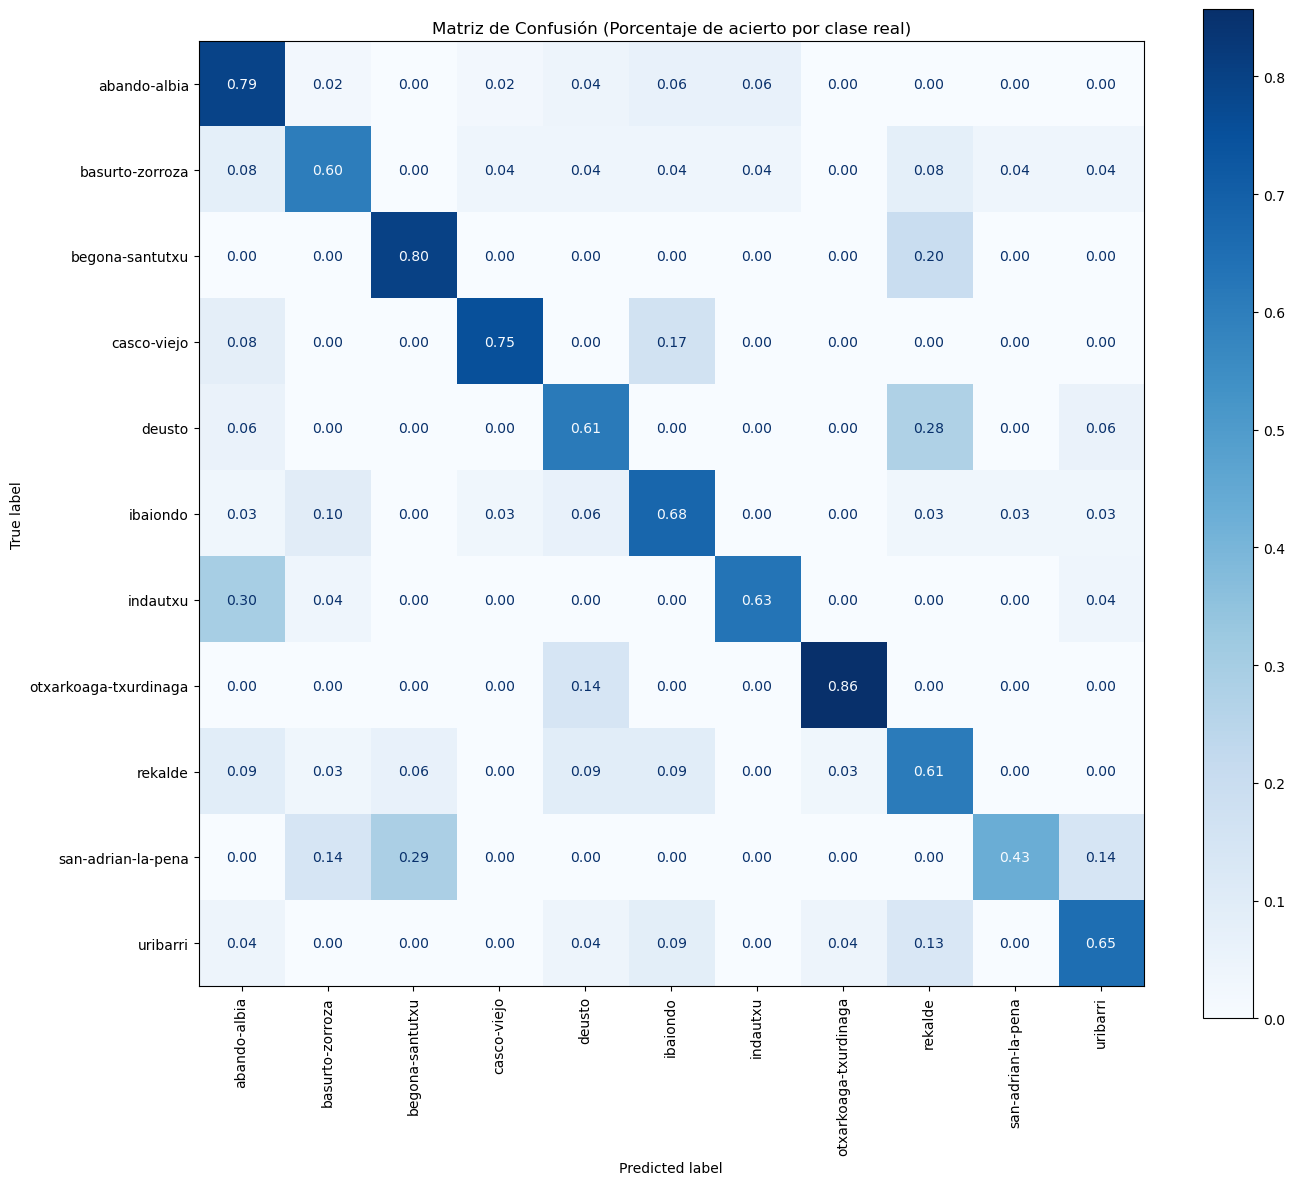

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder

# Temporary encoder for original text zone labels
le_temp = LabelEncoder()
le_temp.fit(y_zone)
class_names = le_temp.classes_

print("Detected zone categories:")
print(class_names)

# Retrieve best Optuna params
best_params = study.best_params
# Add fixed params
best_params['random_state'] = 42
best_params['class_weight'] = 'balanced'
best_params['objective'] = 'multiclass'
best_params['n_jobs'] = -1

# Train/Test split (stratified to preserve minority classes)
X_train, X_test, y_train, y_test = train_test_split(
    X_zone_unencoded_1, y_zone_unencoded_1,
    test_size=0.2,
    stratify=y_zone_unencoded_1,
    random_state=42
)

# Train initial final model
final_model = LGBMClassifier(**best_params)
final_model.fit(X_train, y_train)

# Predict
y_pred = final_model.predict(X_test)

# Classification report
print("\n--- Detailed Classification Report ---")
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion matrix (normalized)
print("\n--- Normalized Confusion Matrix ---")
fig, ax = plt.subplots(figsize=(14, 12))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    ax=ax,
    display_labels=class_names,
    xticks_rotation='vertical',
    cmap='Blues',
    normalize='true',
    values_format=".2f"
)
plt.title("Normalized Confusion Matrix (Recall per True Class)")
plt.tight_layout()
plt.show()

### 15. Feature Importance (Initial Model)

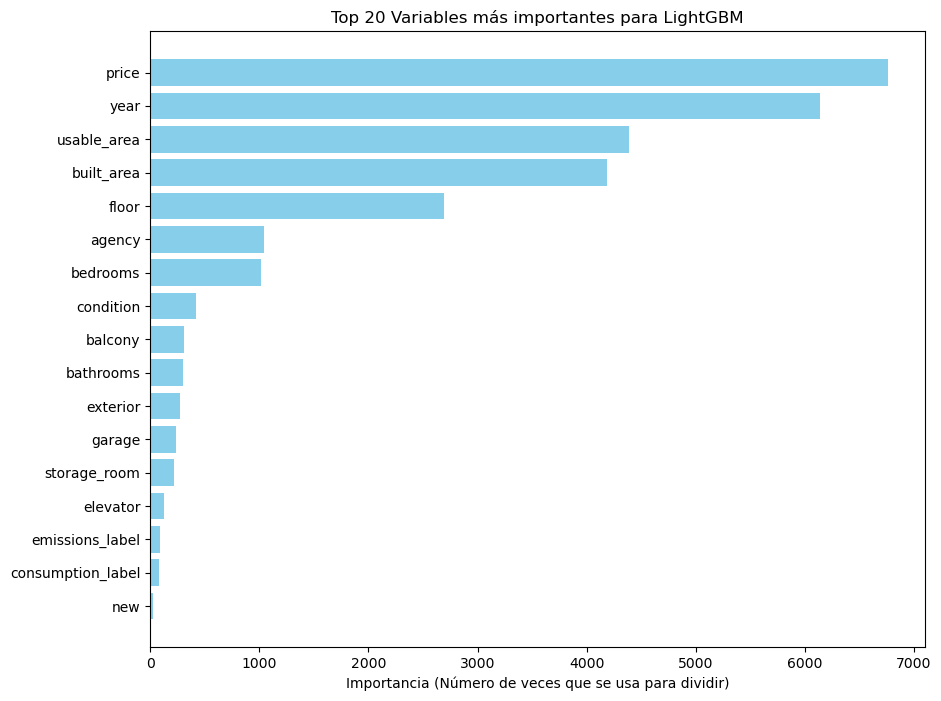

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract importances from initial final model
importances = final_model.feature_importances_
feature_names = X_train.columns

# Build DataFrame and select top 20
df_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
df_imp = df_imp.sort_values(by='importance', ascending=False).head(20)

# Plot top features
plt.figure(figsize=(10, 8))
plt.barh(df_imp['feature'], df_imp['importance'], color='skyblue')
plt.xlabel("Raw importance (split usage frequency)")
plt.gca().invert_yaxis()
plt.title("Top 20 Most Important Features (LightGBM)")
plt.show()

In [ ]:
# Build DataFrame with real vs predicted
results_df = X_test.copy()
results_df['Actual'] = y_test
results_df['Predicted'] = y_pred

# Focus on misclassifications for a minority class (example: class index 9)
errors_class_9 = results_df[(results_df['Actual'] == 9) & (results_df['Predicted'] != 9)]

print(f"Misclassified samples for class 9: {len(errors_class_9)}")
print(errors_class_9[['Actual', 'Predicted']].head(10))

Muestras de Clase 9 mal clasificadas: 4
      Real  Predicho
1225     9        10
1200     9         2
1222     9         2
1228     9         1


### 16. Feature Engineering: Add price_per_m2

Nueva variable creada. Media: 4586.84 €/m2
Entrenando modelo con Price/m2...

--- REPORTE DE CLASIFICACIÓN (CON PRICE/M2) ---
                       precision    recall  f1-score   support

         abando-albia       0.74      0.81      0.77        48
      basurto-zorroza       0.70      0.56      0.62        25
      begona-santutxu       0.73      0.73      0.73        15
          casco-viejo       0.89      0.67      0.76        12
               deusto       0.65      0.61      0.63        18
             ibaiondo       0.59      0.71      0.65        31
             indautxu       0.72      0.78      0.75        27
otxarkoaga-txurdinaga       0.86      0.86      0.86         7
              rekalde       0.62      0.61      0.62        33
   san-adrian-la-pena       0.60      0.43      0.50         7
             uribarri       0.68      0.65      0.67        23

             accuracy                           0.69       246
            macro avg       0.71      0.67      0.69 

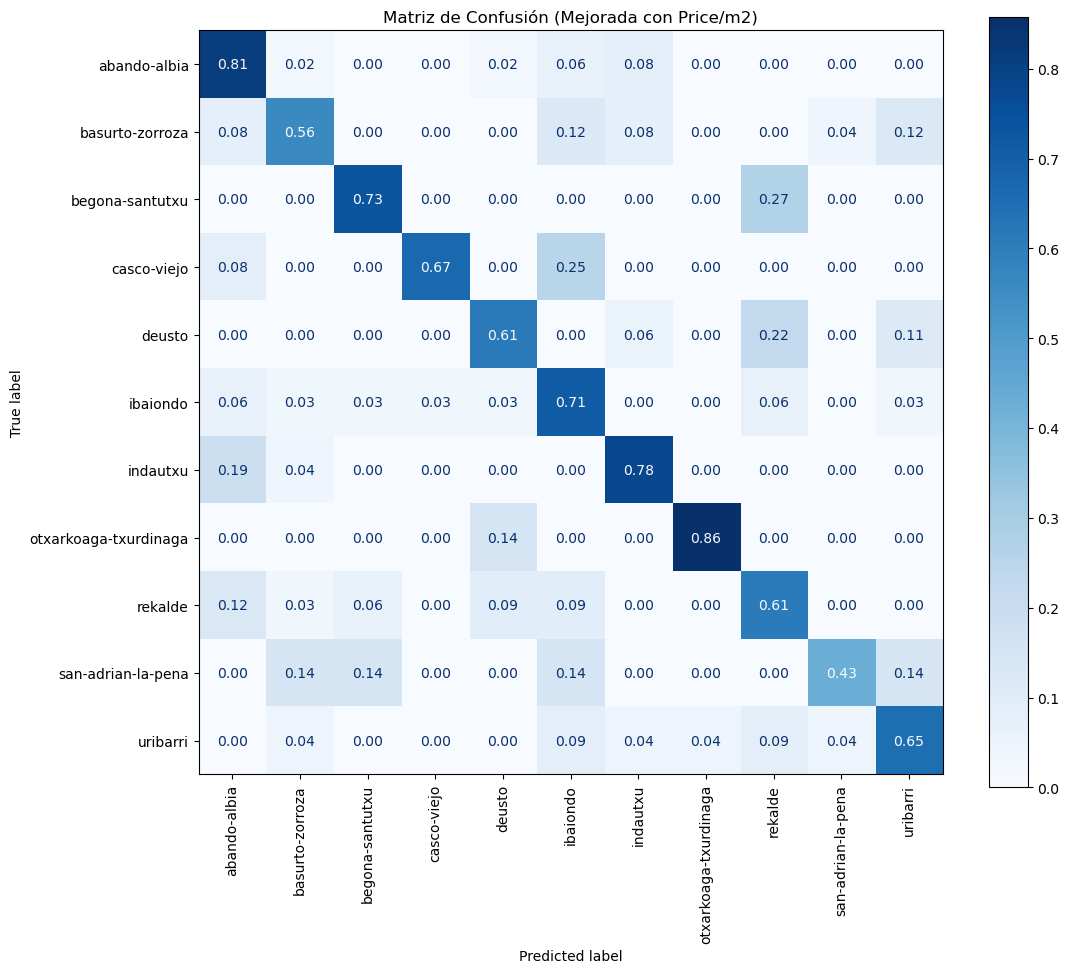

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Create new engineered feature (price per usable area)
X_zone_unencoded_1['price_m2'] = X_zone_unencoded_1['price'] / X_zone_unencoded_1['usable_area']
print(f"New feature 'price_m2' created. Mean: {X_zone_unencoded_1['price_m2'].mean():.2f} €/m2")

# Train/Test split with new feature
X_train, X_test, y_train, y_test = train_test_split(
    X_zone_unencoded_1, y_zone_unencoded_1,
    test_size=0.2,
    stratify=y_zone_unencoded_1,
    random_state=42
)

# Re-train with previously found best parameters (before new Optuna run)
final_model_m2 = LGBMClassifier(**best_params)
print("Training model with price_m2 feature...")
final_model_m2.fit(X_train, y_train)

y_pred_m2 = final_model_m2.predict(X_test)

print("\n--- Classification Report (with price_m2) ---")
print(classification_report(y_test, y_pred_m2, target_names=class_names))

# Feature importance (top 10)
importances = final_model_m2.feature_importances_
df_imp = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
df_imp = df_imp.sort_values(by='Importance', ascending=False).head(10)
print("\n--- Top 10 Features (with price_m2) ---")
print(df_imp)

# Normalized confusion matrix for comparison
fig, ax = plt.subplots(figsize=(12, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_m2,
    ax=ax,
    display_labels=class_names,
    xticks_rotation='vertical',
    cmap='Blues',
    normalize='true',
    values_format=".2f"
)
plt.title("Confusion Matrix (Enhanced with price_m2)")
plt.show()

### 17. Optuna Re-Optimization Including price_per_m2

In [ ]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Re-optimize after adding price_m2

def objective(trial):
    param = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'class_weight': 'balanced',
        'n_jobs': -1,
        'n_estimators': trial.suggest_int('n_estimators', 200, 800),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 60),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 30),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 5.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 5.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'subsample_freq': 1
    }
    model = LGBMClassifier(**param)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_zone_unencoded_1, y_zone_unencoded_1, cv=cv, scoring='f1_macro', n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction='maximize')
print("Re-optimizing with engineered feature price_m2 (50 trials)...")
study.optimize(objective, n_trials=50)

print(f"Final Best Macro F1 with price_m2: {study.best_value:.4f}")

[I 2025-11-23 12:39:04,193] A new study created in memory with name: no-name-7d00e2b1-e504-4fab-92b9-07a6faac67f9


Re-optimizando con la nueva variable price_m2...


[I 2025-11-23 12:39:21,139] Trial 0 finished with value: 0.6628834075708745 and parameters: {'n_estimators': 522, 'learning_rate': 0.05477830754476141, 'num_leaves': 35, 'max_depth': 5, 'min_child_samples': 22, 'reg_alpha': 0.009643732355585204, 'reg_lambda': 0.5453005803348101, 'colsample_bytree': 0.7138916788450563, 'subsample': 0.6750223247986047}. Best is trial 0 with value: 0.6628834075708745.
[I 2025-11-23 12:39:49,053] Trial 1 finished with value: 0.6552759888692726 and parameters: {'n_estimators': 781, 'learning_rate': 0.06419905089440514, 'num_leaves': 51, 'max_depth': 10, 'min_child_samples': 20, 'reg_alpha': 0.029869459655473007, 'reg_lambda': 1.7323868982743853, 'colsample_bytree': 0.8405493806915192, 'subsample': 0.9121400420306772}. Best is trial 0 with value: 0.6628834075708745.
[I 2025-11-23 12:40:13,437] Trial 2 finished with value: 0.6442108628731951 and parameters: {'n_estimators': 573, 'learning_rate': 0.011365441215982736, 'num_leaves': 55, 'max_depth': 6, 'min_chi

Mejor Score Final: 0.6702


Entrenando el modelo CAMPEÓN...

--- REPORTE FINAL DE CLASIFICACIÓN ---
                       precision    recall  f1-score   support

         abando-albia       0.76      0.88      0.82        48
      basurto-zorroza       0.78      0.56      0.65        25
      begona-santutxu       0.71      0.80      0.75        15
          casco-viejo       0.88      0.58      0.70        12
               deusto       0.63      0.67      0.65        18
             ibaiondo       0.62      0.74      0.68        31
             indautxu       0.74      0.74      0.74        27
otxarkoaga-txurdinaga       0.78      1.00      0.88         7
              rekalde       0.67      0.61      0.63        33
   san-adrian-la-pena       0.60      0.43      0.50         7
             uribarri       0.76      0.70      0.73        23

             accuracy                           0.72       246
            macro avg       0.72      0.70      0.70       246
         weighted avg       0.72      0.72  

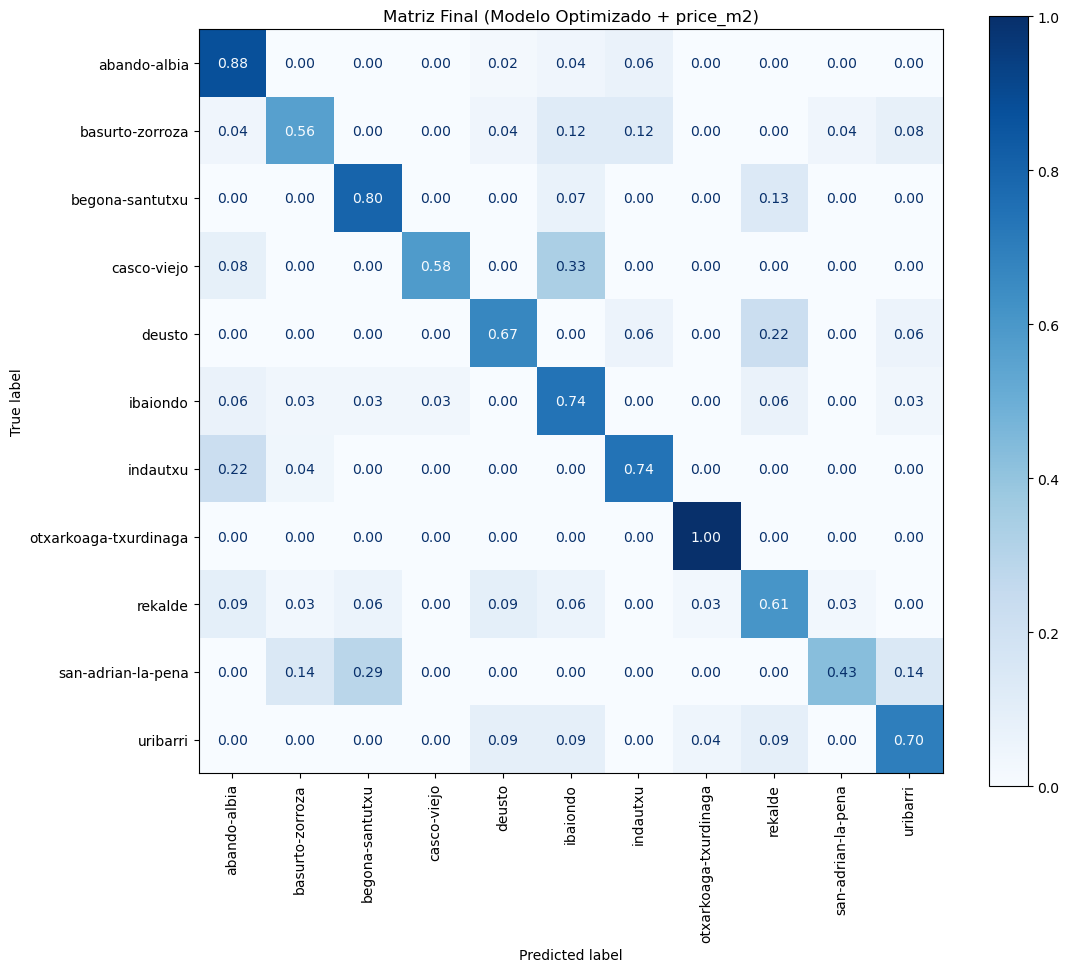

C:\Users\iker\AppData\Local\Temp\ipykernel_12896\4160011889.py:61: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




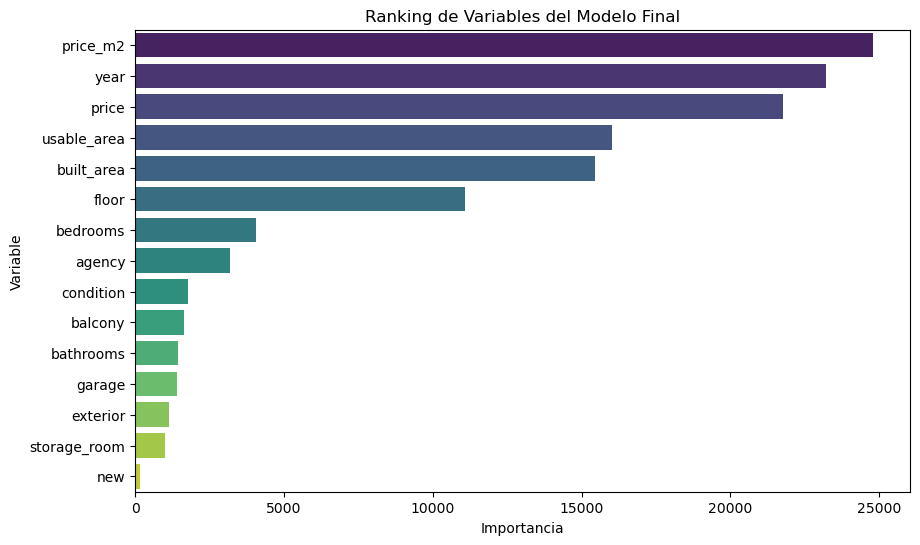

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
import pandas as pd
import seaborn as sns

# Champion model parameters from latest Optuna run
best_params = study.best_params

# Add fixed parameters
best_params['random_state'] = 42
best_params['class_weight'] = 'balanced'
best_params['objective'] = 'multiclass'
best_params['n_jobs'] = -1
best_params['verbose'] = -1

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_zone_unencoded_1, y_zone_unencoded_1,
    test_size=0.2,
    stratify=y_zone_unencoded_1,
    random_state=42
)

print("Training champion LightGBM model...")
final_model = LGBMClassifier(**best_params)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

print("\n--- Final Classification Report ---")
print(classification_report(y_test, y_pred, target_names=class_names))

print("\n--- Final Normalized Confusion Matrix ---")
fig, ax = plt.subplots(figsize=(12, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    ax=ax,
    display_labels=class_names,
    xticks_rotation='vertical',
    cmap='Blues',
    normalize='true',
    values_format=".2f"
)
plt.title("Final Confusion Matrix (Optimized + price_m2)")
plt.show()

# Feature importance ranking
importances = final_model.feature_importances_
df_imp = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
df_imp = df_imp.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_imp, x='Importance', y='Feature', palette='viridis')
plt.title('Final Feature Importance Ranking')
plt.show()

In [43]:
import joblib

# Persist final model
joblib.dump(final_model, 'bilbao_zone_classifier_lgbm.pkl')
print("Model saved as 'modelo_barrios_bilbao_lgbm.pkl'")


Model saved as 'modelo_barrios_bilbao_lgbm.pkl'
